In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# Load the data
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/kaggle data/Train",
    image_size=(224, 224),
    batch_size=32
)

Found 4900 files belonging to 3 classes.


In [8]:
val_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/kaggle data/Val",
    image_size=(224, 224),
    batch_size=32
)

Found 1050 files belonging to 3 classes.


In [9]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/kaggle data/Test",
    image_size=(224, 224),
    batch_size=32
)


Found 1050 files belonging to 3 classes.


In [10]:
for image_batch, label_batch in train_set:
    print(image_batch.shape)
    break


(32, 224, 224, 3)


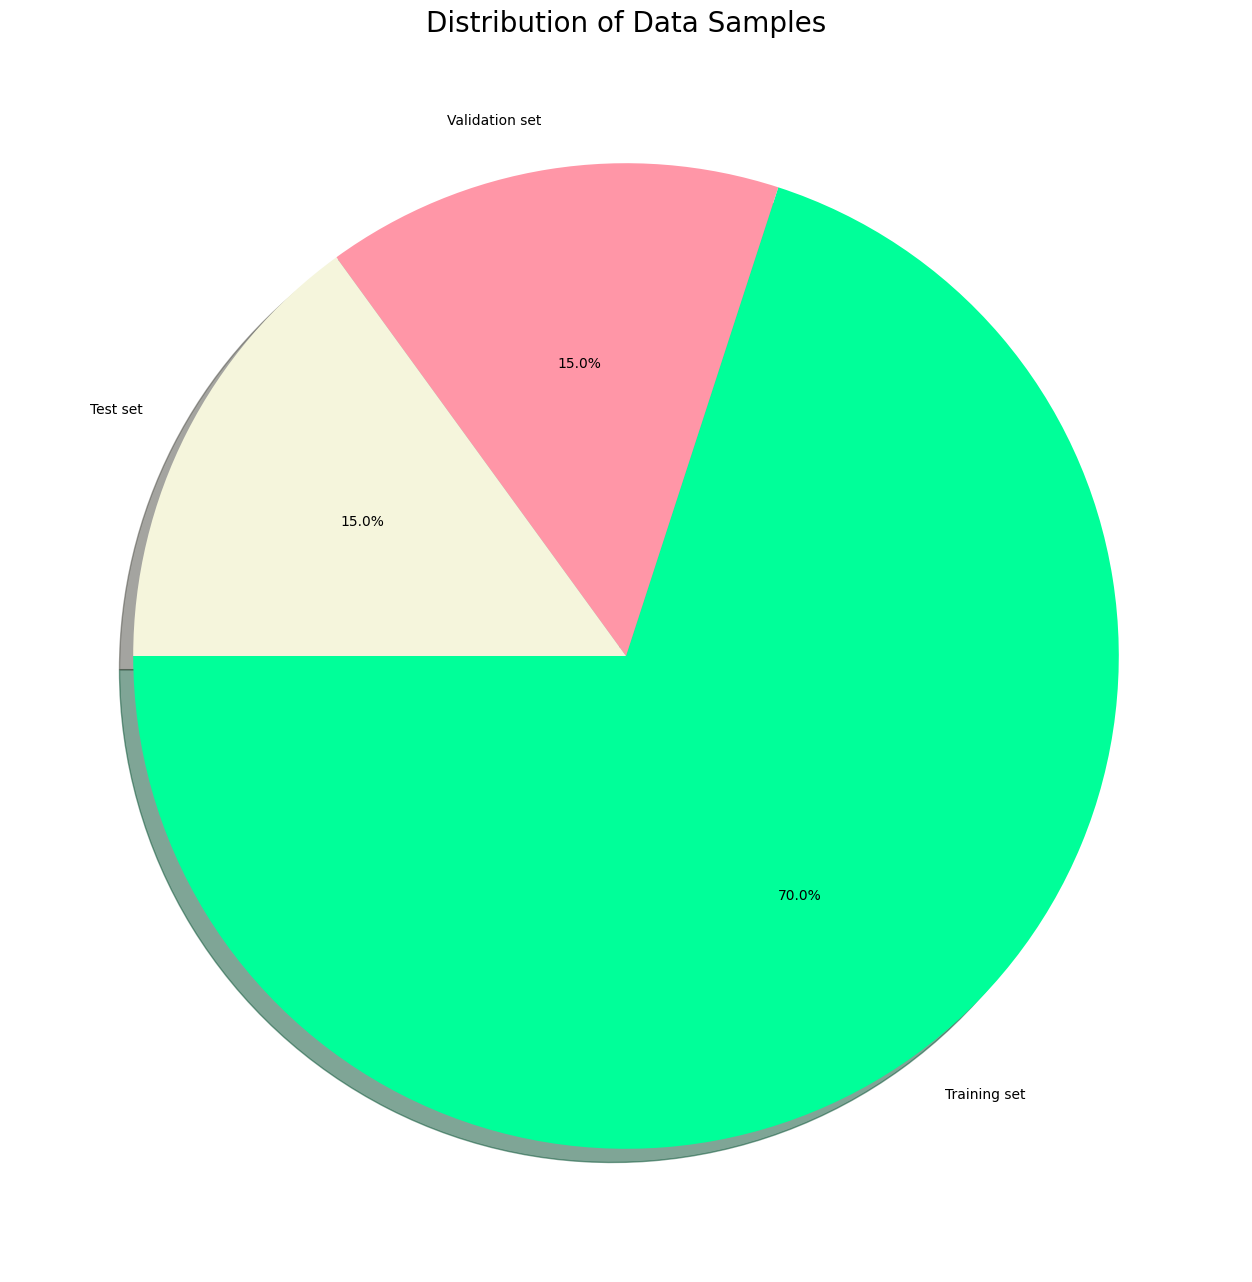

In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Training set', 'Validation set', 'Test set']

# Get the number of samples in each set
labels_count = [len(train_set), len(val_set), len(test_set)]

# Create the pie chart
plt.figure(figsize=(16, 16))
plt.pie(labels_count, labels=class_names, startangle=180,
        autopct='%1.1f%%', colors=['#00ff99', '#FF96A7',"beige"], shadow=True)
plt.title('Distribution of Data Samples', fontsize=20)
plt.show()


In [12]:
class_names = ['adenocarcinoma', 'benign', 'squamous_carcinoma']
print(class_names)

['adenocarcinoma', 'benign', 'squamous_carcinoma']


In [13]:

IMAGE_SIZE = [224, 224]

In [14]:
# Load the InceptionV3 model
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


87910968/87910968 [==============================] - 0s 0us/step


In [15]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [19]:


import tensorflow as tf
from tensorflow.keras import layers

class RPN(tf.keras.Model):
    def __init__(self, num_anchors):
        super(RPN, self).__init__()
        self.conv = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')
        self.cls_layer = layers.Conv2D(num_anchors, kernel_size=1)
        self.reg_layer = layers.Conv2D(num_anchors * 4, kernel_size=1)

    def call(self, inputs):
        x = self.conv(inputs)
        cls_logits = self.cls_layer(x)
        reg_deltas = self.reg_layer(x)
        return [cls_logits, reg_deltas]

class FasterRCNN(tf.keras.Model):
    def __init__(self, num_classes, num_anchors):
        super(FasterRCNN, self).__init__()
        self.backbone = ResNet50()  # Replace with your desired backbone network
        self.rpn = RPN(num_anchors)
        self.roi_align = layers.RoIAlign(pool_size=7, stride=2)
        self.classifier = layers.Dense(num_classes, activation='softmax')
        self.regressor = layers.Dense(4)

    def call(self, inputs):
        # Feature extraction
        features = self.backbone(inputs)

        # Region proposal network
        cls_logits, reg_deltas = self.rpn(features)

        # Generate region proposals
        proposals = generate_proposals(cls_logits, reg_deltas)

        # Extract ROI features
        roi_features = self.roi_align(features, proposals)

        # Classification and regression
        class_predictions = self.classifier(roi_features)
        bbox_predictions = self.regressor(roi_features)

        return [class_predictions, bbox_predictions, proposals]

# Define the ResNet50 backbone network
class ResNet50(tf.keras.Model):
    def __init__(self):
        super(ResNet50, self).__init__()
        # Define the layers of the ResNet50 network here

In [20]:
# tell the model what cost and optimization method to use
model.compile(
  loss='SparseCategoricalCrossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [21]:

import time
start_time=time.time()
history= model.fit(
  train_set,
  validation_data=val_set,
  epochs=30,
  steps_per_epoch=len(train_set),
  validation_steps=len(val_set)
)
end_time=time.time()
elapsed_time=end_time=start_time
print(f"Elapsed time: {elapsed_time} seconds")


Epoch 1/30
154/154 [==============================] - 1267s 8s/step - loss: 5.4379 - accuracy: 0.6976 - val_loss: 2.5704 - val_accuracy: 0.7867
Epoch 2/30
154/154 [==============================] - 673s 4s/step - loss: 2.3990 - accuracy: 0.7610 - val_loss: 0.9440 - val_accuracy: 0.8362
Epoch 3/30
154/154 [==============================] - 652s 4s/step - loss: 1.3351 - accuracy: 0.7922 - val_loss: 2.9232 - val_accuracy: 0.6314
Epoch 4/30
154/154 [==============================] - 676s 4s/step - loss: 0.7375 - accuracy: 0.8141 - val_loss: 1.1111 - val_accuracy: 0.7600
Epoch 5/30
154/154 [==============================] - 646s 4s/step - loss: 0.5158 - accuracy: 0.8335 - val_loss: 0.5564 - val_accuracy: 0.8486
Epoch 6/30
154/154 [==============================] - 676s 4s/step - loss: 0.6757 - accuracy: 0.8049 - val_loss: 0.5079 - val_accuracy: 0.8190
Epoch 7/30
154/154 [==============================] - 685s 4s/step - loss: 0.3571 - accuracy: 0.8580 - val_loss: 0.3884 - val_accuracy: 0.849

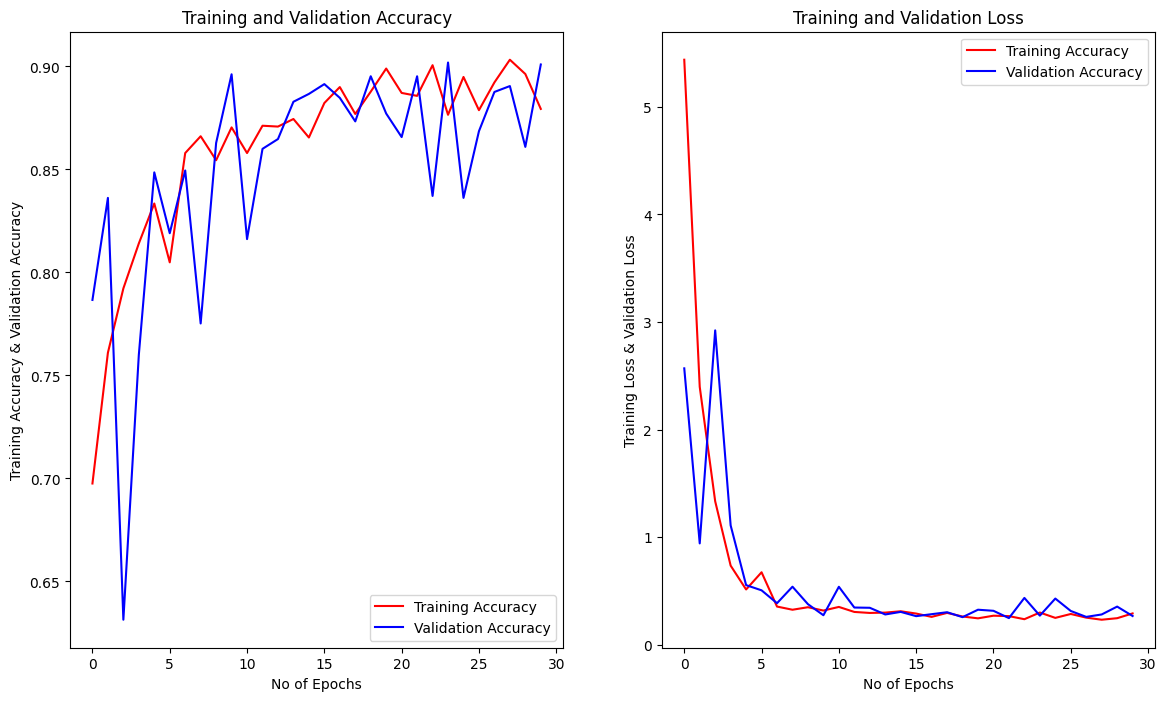

In [22]:
# Extract the metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the results
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy',color='red')
plt.plot(range(len(acc)), val_acc, label='Validation Accuracy',color='blue')
plt.xlabel('No of Epochs')
plt.ylabel('Training Accuracy & Validation Accuracy')
plt.title('Visualization of Training Accuracy & Validation Accuracy Result')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Accuracy',color='red')
plt.plot(range(len(val_loss)), val_loss, label='Validation Accuracy',color='blue')
plt.xlabel('No of Epochs')
plt.ylabel('Training Loss & Validation Loss')
plt.title('Visualization of Training Loss & Validation Loss Result')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
loss,accuracy=model.evaluate(train_set)
accuracy*100

154/154 [==============================] - 528s 3s/step - loss: 0.2156 - accuracy: 0.9143


91.42857193946838

In [24]:
val_loss,val_accuracy=model.evaluate(val_set)
val_accuracy*100

33/33 [==============================] - 113s 3s/step - loss: 0.2693 - accuracy: 0.9010


90.0952398777008

In [25]:
test_loss,test_accuracy=model.evaluate(test_set)
test_accuracy*100

33/33 [==============================] - 298s 7s/step - loss: 0.2417 - accuracy: 0.9171


91.71428680419922

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

first image to predict
actual label: adenocarcinoma
1/1 [==============================] - 6s 6s/step
predicted label: adenocarcinoma


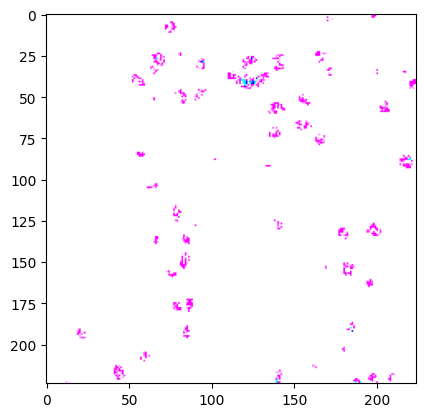

In [27]:
import numpy as np
for images_batch, labels_batch in test_set:

    first_image = images_batch[0]
    first_label = int(labels_batch[0])

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 135ms/step


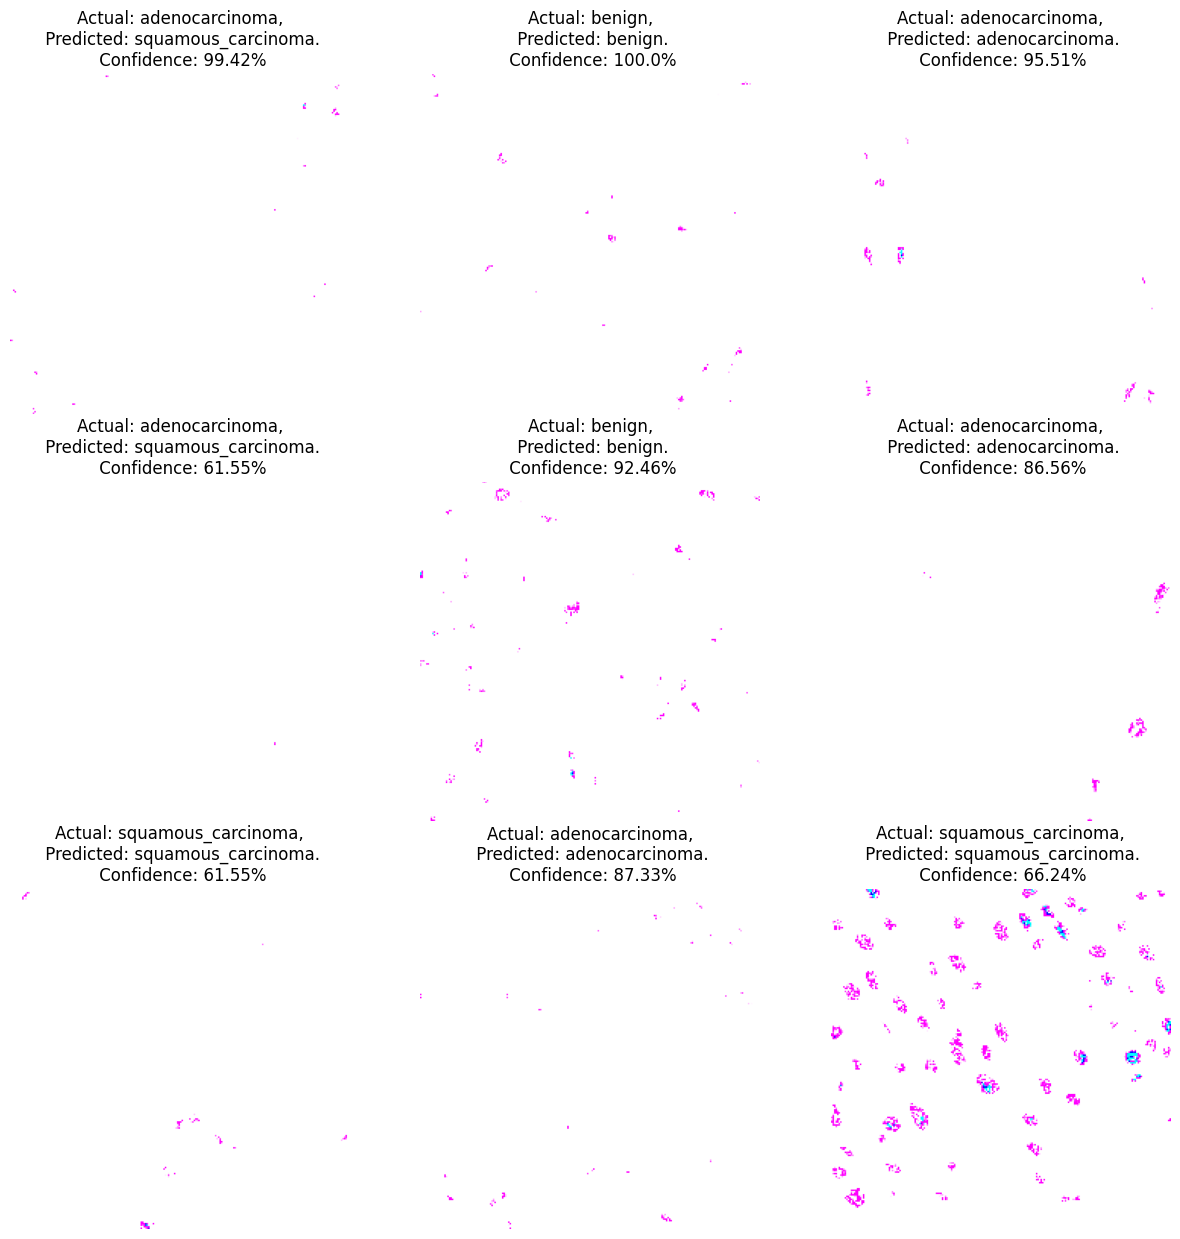

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_set:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break

Generating predictions...
4/4 [==============================] - 13s 3s/step
Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.77      0.88      0.82        34
            benign       0.98      0.96      0.97        49
squamous_carcinoma       0.93      0.84      0.88        45

          accuracy                           0.90       128
         macro avg       0.89      0.90      0.89       128
      weighted avg       0.91      0.90      0.90       128

Generating confusion matrix...


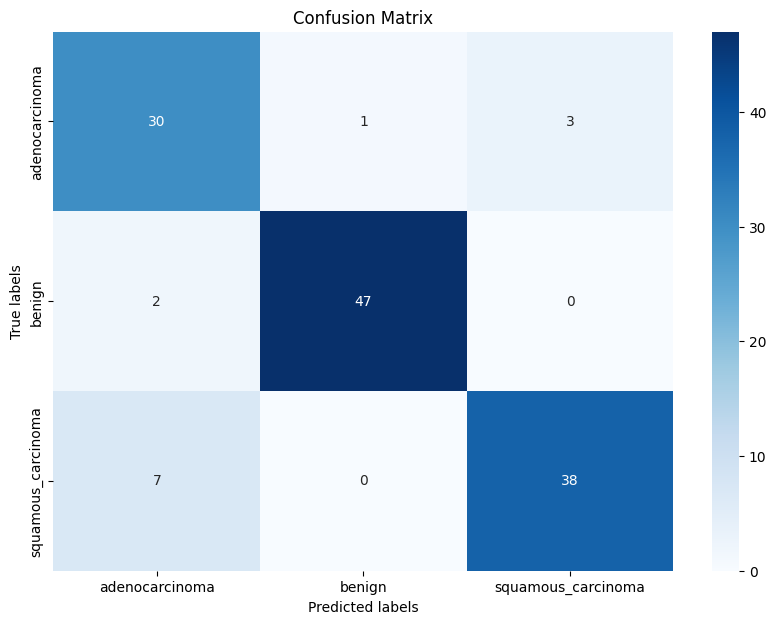

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions on a subset of the test set
subset_size = 100  # Adjust the subset size as needed
test_images_subset, test_labels_subset = [], []
for images, labels in test_set:
    if len(test_images_subset) < subset_size:
        test_images_subset.extend(images)
        test_labels_subset.extend(labels)
    else:
        break
test_images_subset = np.array(test_images_subset)
test_labels_subset = np.array(test_labels_subset)

# Generate predictions
print("Generating predictions...")
y_pred_subset = model.predict(test_images_subset)
y_pred_classes_subset = np.argmax(y_pred_subset, axis=1)

# Generate classification report
class_names = ['adenocarcinoma', 'benign', 'squamous_carcinoma']  # Replace with your class names
print("Classification Report:")
print(classification_report(test_labels_subset, y_pred_classes_subset, target_names=class_names))

# Generate confusion matrix
print("Generating confusion matrix...")
cm_subset = confusion_matrix(test_labels_subset, y_pred_classes_subset)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()